In [1]:
try:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import classification_report, accuracy_score
    import data_loader as dl
    import gensim.downloader as api
    from collections import Counter
    from sklearn.utils.class_weight import compute_class_weight

    print("All imports successful!")

except ImportError as e:
    print(f"ImportError: {e}")

All imports successful!


In [2]:
glove_model = api.load("glove-wiki-gigaword-300")


In [3]:
df = dl.get_clean_sentences_and_labels_only_corrected()


In [5]:
portuguese_df = df[df['l1'] == 'Portuguese']
portuguese_sampled = portuguese_df.sample(n=40000, random_state=42)
df_non_portuguese = df[df['l1'] != 'Portuguese']

mandarin_df = df[df['l1'] == 'Mandarin']
mandarin_sampled = mandarin_df.sample(n=40000, random_state=42)
df_non_portuguese_non_mandarin = df_non_portuguese[df_non_portuguese['l1'] != 'Mandarin']

# Combine the sampled rows with the rest of the data
df = pd.concat([df_non_portuguese_non_mandarin, portuguese_sampled, mandarin_sampled], ignore_index=True)

In [6]:
def preprocess_sentence(sentence):
    return [word for word in sentence.lower().split() if word in glove_model.key_to_index]

def embed_sentence(sentence):
    words = preprocess_sentence(sentence)
    if words:
        return np.mean([glove_model[word] for word in words], axis=0)
    else:
        return np.zeros(glove_model.vector_size)

In [7]:
def data_generator(df, batch_size):
    for start in range(0, len(df), batch_size):
        end = start + batch_size
        batch = df.iloc[start:end]
        X_batch = np.array([embed_sentence(sentence) for sentence in batch['sentences_corrected']])
        y_batch = batch['encoded_labels'].values
        yield X_batch, y_batch

In [8]:
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['l1'])

# class_weights = compute_class_weight('balanced', classes=np.unique(df['encoded_labels']), y=df['encoded_labels'])
# class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

model = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')
batch_size = 5000

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

classes = np.unique(df['encoded_labels'])

first_batch = True
for X_batch, y_batch in data_generator(df_train, batch_size):
    if first_batch:
        model.partial_fit(X_batch, y_batch, classes=classes)
        first_batch = False
    else:
        model.partial_fit(X_batch, y_batch)


In [9]:
def aggregate_sentence_predictions(df, model, label_encoder):
    text_ids = df['text_id'].unique()
    final_predictions = []

    for text_id in text_ids:
        # Get all sentences for this text
        sentences_df = df[df['text_id'] == text_id]
        X_sentences = np.array([embed_sentence(sentence) for sentence in sentences_df['sentences_corrected']])

        # Predict probabilities for each sentence
        sentence_probabilities = model.predict_proba(X_sentences)

        # Aggregate probabilities by summing them up for each class
        summed_probabilities = np.sum(sentence_probabilities, axis=0)

        # Get the class with the highest summed probability
        predicted_label_idx = np.argmax(summed_probabilities)

        # Decode the label back to the original label
        final_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        final_predictions.append((text_id, final_label))

    return final_predictions

final_predictions = aggregate_sentence_predictions(df_test, model, label_encoder)

true_labels = df_test.groupby('text_id')['l1'].first()
predicted_labels = [pred for _, pred in final_predictions]

accuracy = accuracy_score(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)

print(f"Final Text-Level Accuracy: {accuracy}")
print(f"Final Text-Level Classification Report:\n{report}")

Final Text-Level Accuracy: 0.1625075812415628
Final Text-Level Classification Report:
              precision    recall  f1-score   support

      Arabic       0.08      0.01      0.02     17263
      French       0.10      0.01      0.01     22480
      German       0.15      0.49      0.23     30856
     Italian       0.12      0.01      0.02     23900
    Japanese       0.08      0.00      0.00     12168
    Mandarin       0.00      0.00      0.00      7725
  Portuguese       0.14      0.00      0.00      7781
     Russian       0.18      0.35      0.24     36815
     Spanish       0.18      0.12      0.15     38500
     Turkish       0.00      0.00      0.00      6964

    accuracy                           0.16    204452
   macro avg       0.10      0.10      0.07    204452
weighted avg       0.13      0.16      0.11    204452



In [10]:
text_level_labels = df.groupby('text_id')['l1'].first()
label_counts_text_level = text_level_labels.value_counts()

print("Counts for each true label at the text level:")
print(label_counts_text_level)

Counts for each true label at the text level:
l1
Spanish       64744
Russian       49304
German        41418
Portuguese    37488
Italian       35414
Mandarin      33341
French        32504
Arabic        29292
Japanese      17084
Turkish       10303
Name: count, dtype: int64


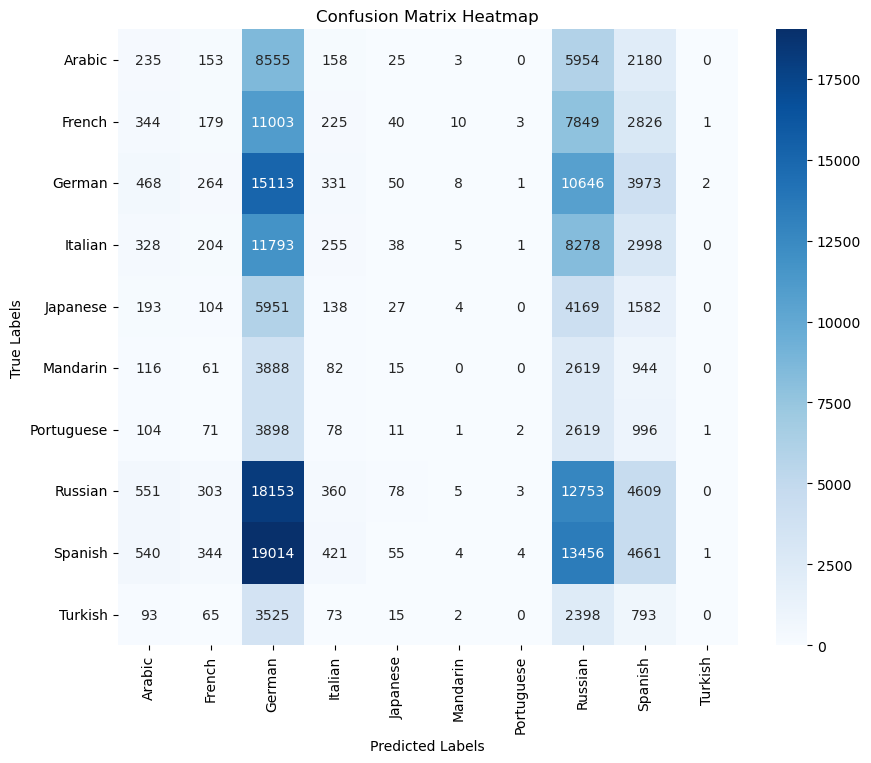

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [32]:
predictions_df = pd.DataFrame(final_predictions, columns=['text_id', 'predicted_label'])
df_test_with_predictions = df_test.merge(predictions_df, on='text_id', how='left')

In [34]:
original_data_df = dl.load_data("data.parquet", ["Final database (main prompts).xlsx",
                                                 "Final database (alternative prompts).xlsx"])
original_data_df['text_id'] = range(1, len(original_data_df) + 1)


In [35]:
df_for_filtering = original_data_df.merge(df_test_with_predictions, on='text_id', how='right')

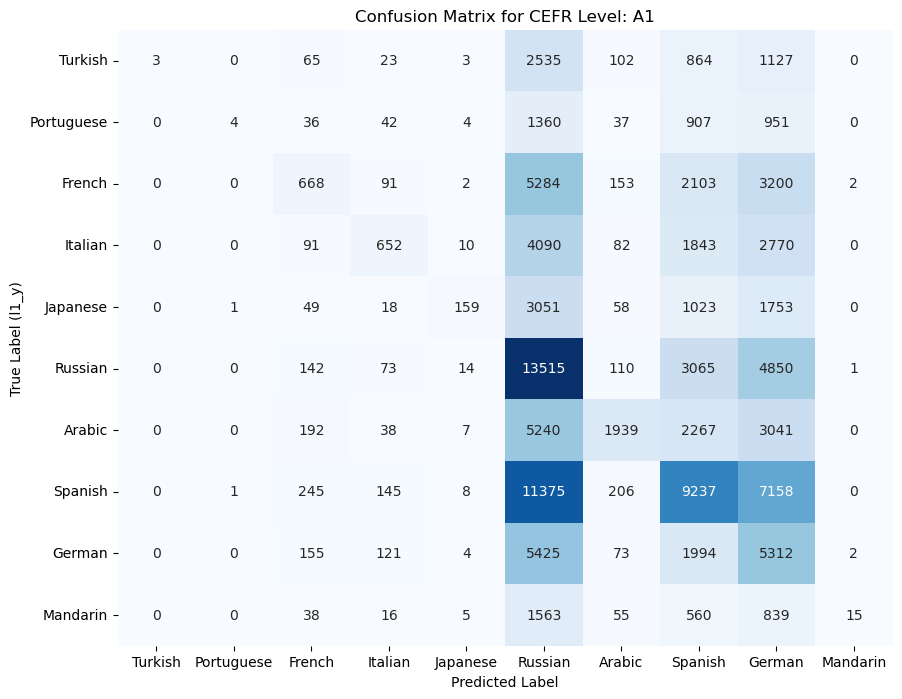

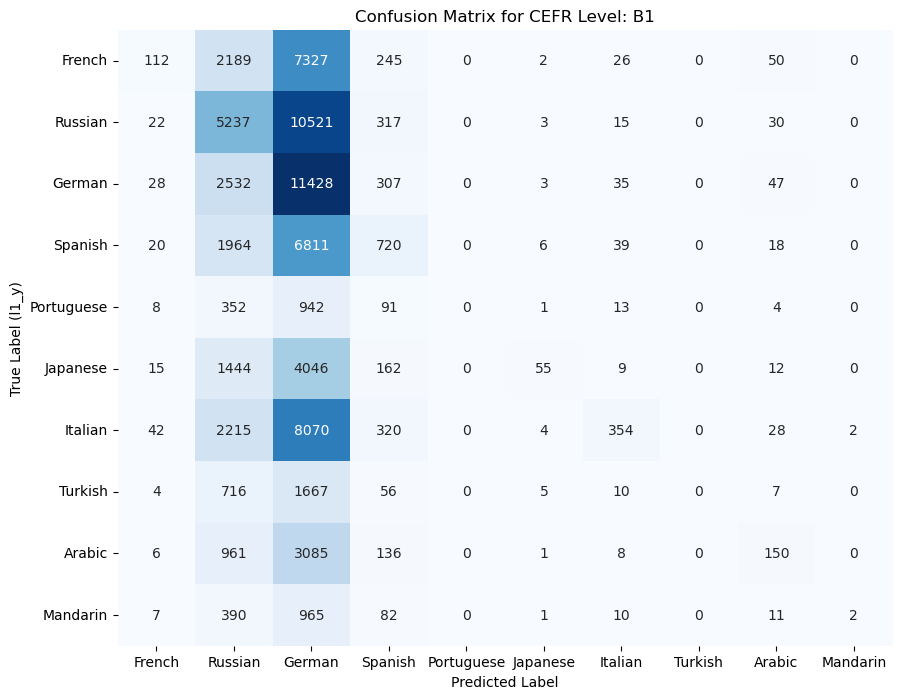

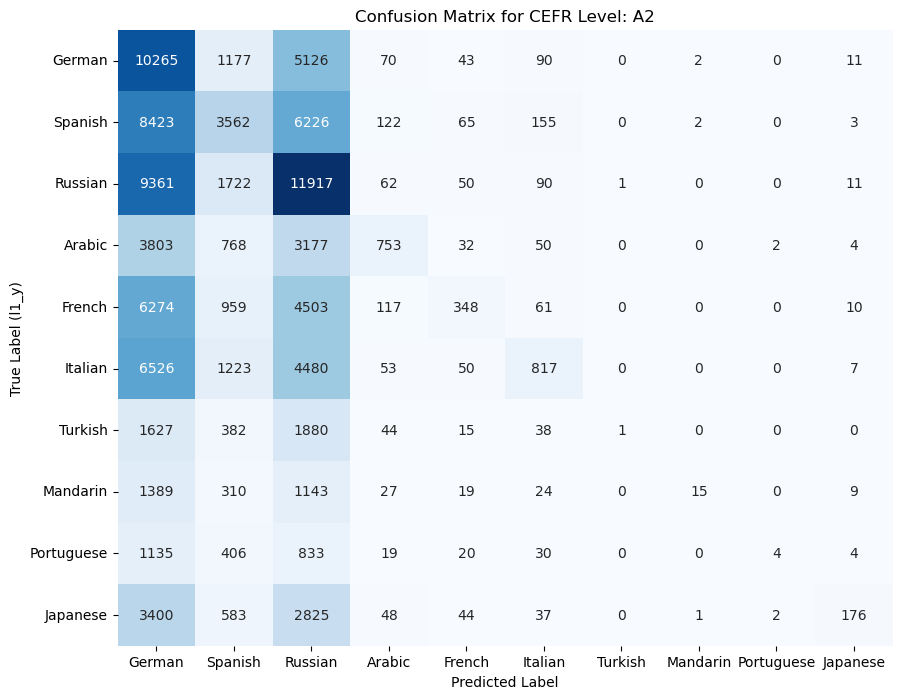

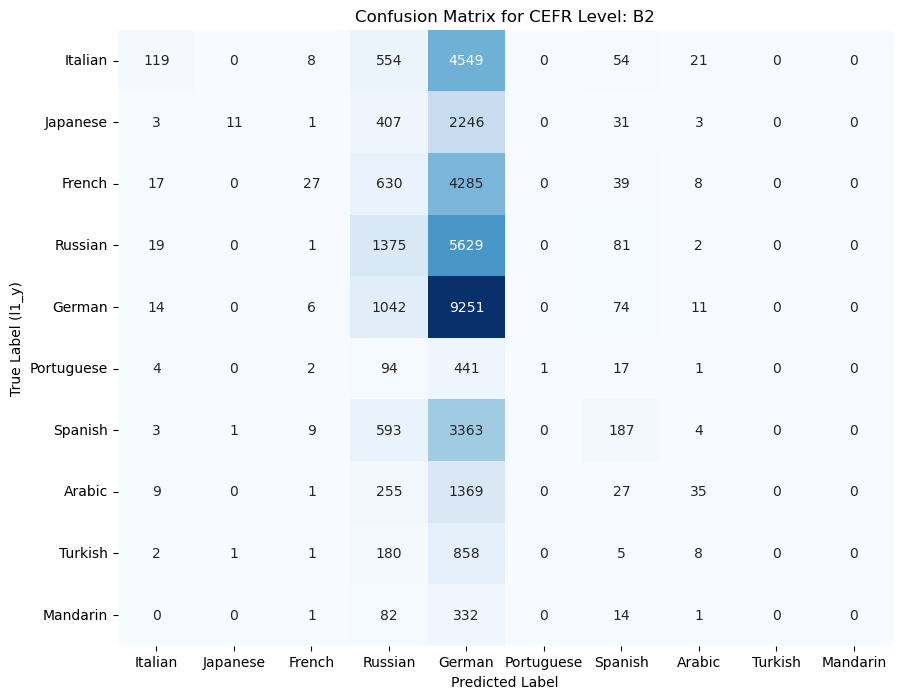

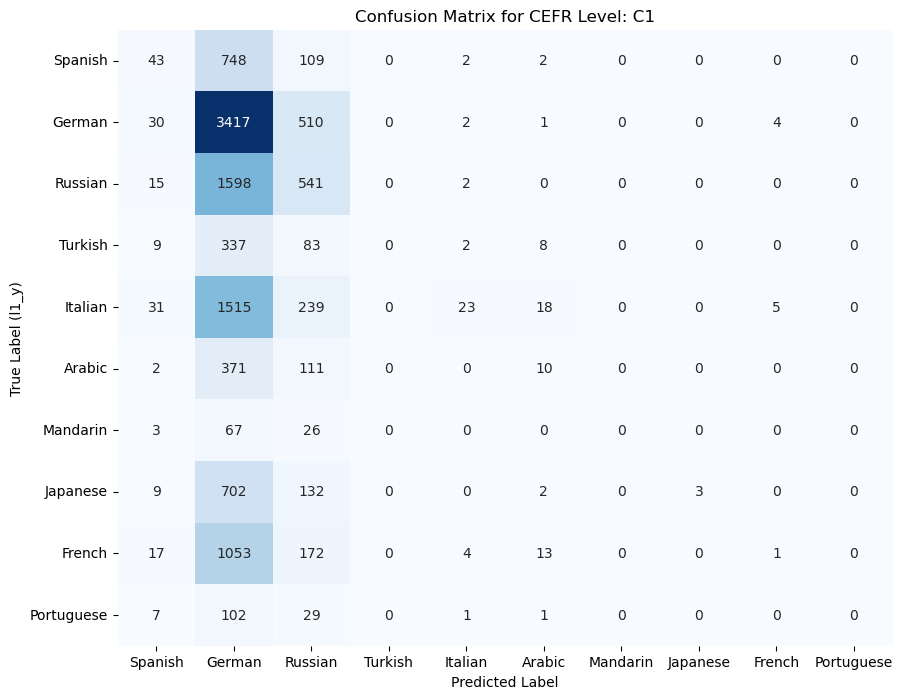

In [39]:
cefr_levels = df_for_filtering['cefr'].unique()

for cefr in cefr_levels:
    # Filter the DataFrame for the current CEFR level
    df_cefr = df_for_filtering[df_for_filtering['cefr'] == cefr]
    
    # Create a confusion matrix
    cm = confusion_matrix(df_cefr['l1_y'], df_cefr['predicted_label'], labels=df_cefr['l1_y'].unique())
    
    # Create a DataFrame from the confusion matrix for easier plotting
    cm_df = pd.DataFrame(cm, index=df_cefr['l1_y'].unique(), columns=df_cefr['l1_y'].unique())
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for CEFR Level: {cefr}')
    plt.ylabel('True Label (l1_y)')
    plt.xlabel('Predicted Label')
    plt.show()